# Practica 1 Bloque 2 - Mineria de textos.

## Entrenamiento y ejecución de un pipeline de clasificación textual

### Obtencion del dataset y del archivo tripadvisor.py

La obtención del archivo $tripadvisor.py$ la hago con el comando $wget$ para no tener que descargar nada localmente para ejecutar la notebook.

In [3]:
!wget https://raw.githubusercontent.com/TeachingTextMining/TextClassification/main/00-Utils/tripadvisor.py

--2024-03-07 20:26:23--  https://raw.githubusercontent.com/TeachingTextMining/TextClassification/main/00-Utils/tripadvisor.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 968 [text/plain]
Saving to: ‘tripadvisor.py.4’

tripadvisor.py.4    100%[===================>]     968  --.-KB/s    in 0s      

2024-03-07 20:26:24 (31,8 MB/s) - ‘tripadvisor.py.4’ saved [968/968]



Una vez obtenido el archivo con las funciones, utilizo la función $loadDataTripadvisor$ para obtener el conjunto de opiniones de los usuarios, en el dataframe llamado $data$.

In [4]:


import tripadvisor

ruta_archivo = 'https://raw.githubusercontent.com/TeachingTextMining/TextClassification/main/01-SA-Pipeline/sample_data/ejercicio_tripadvisor.csv'

data = tripadvisor.load_data_tripadvisor(ruta_archivo)

data

,text,score,Opinion,PROS,CONS,Sentiment
274573_7795529,Good for the money Having read the reviews -...,4,Good for the money Having read the reviews -...,Location and Price,Beds,2
274573_6611183,Central location and good price Hotel Suisse...,3,Central location and good price Hotel Suisse...,NaN,NaN,1
274573_5823077,A great hotel in the middle of everything I...,3,A great hotel in the middle of everything I...,Location,Having to be buzzed in,1
274573_5326023,Great location but expensive and some restric...,3,Great location but expensive and some restric...,NaN,NaN,1
274573_5211722,Great comfort and value Comfortable and clea...,4,Great comfort and value Comfortable and clea...,NaN,NaN,2
...,...,...,...,...,...,...
203223_1138851,Great Location Spent 4 nights at the Hotel D...,4,Great Location Spent 4 nights at the Hotel D...,NaN,NaN,2
203223_1104333,Hotel Duca d'Alba is your best bet in Rome W...,5,Hotel Duca d'Alba is your best bet in Rome W...,NaN,NaN,2
203223_1091527,Great hotel great location good price This...,5,Great hotel great location good price This...,NaN,NaN,2
203223_1077664,Convenient quiet neighborhood hotel Conveni...,4,Convenient quiet neighborhood hotel Conveni...,NaN,NaN,2


### Importación de librerías necesarias.

In [5]:


# Descargar Spacy y el paquete de idioma en caso de ser necesario
!pip install -U spacy
!python -m spacy download es_core_news_sm

In [6]:
#  para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

# para cargar datos y realizar pre-procesamiento básico
import pandas as pd
from collections import Counter

# para pre-procesamiento del texto y extraer características
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import EnglishStemmer

# algoritmos de clasificación
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# para construir pipelines
from sklearn.pipeline import Pipeline

# para evaluar los modelos 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

# para guardar el modelo
import pickle


# Librerias utilizadas por mi para diferentes tareas, como la definición del pipeline, la importación de diferentes clasificadores y la creación de gráficos.
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion
from nltk.corpus import wordnet
import spacy
import es_core_news_sm
import matplotlib.pyplot as plt

# Descargar los recursos de NLTK (para la tercera y cuarta pipeline: filtrar por adjetivos y nombres)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

print('Done!')

Done!


[nltk_data] Downloading package punkt to /Users/stefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/stefan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/stefan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Definición de funciones y variables necesarias para el pre-procesamiento de datos

In [7]:
#listado de stopwords. Este listado también se puede leer desde un fichero utilizando la función read_corpus
stop_words=['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves',
            'he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their',
            'theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are',
            'was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an',
            'the','and','but','if','or','because','as','until','while','of','at','by','for','with','about',
            'against','between','into','through','during','before','after','above','below','to','from','up',
            'down','in','out','on','off','over','under','again','further','then','once','here','there','when',
            'where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor',
            'not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'ever']


# función auxiliar. Se utiliza al obtener la representación mediante TF-IDF del texto pues en este caso
# se removerán las stop_words y se considerarán los "stem" en lugar de las palabrass
def english_stemmer(sentence):
    stemmer = EnglishStemmer()
    analyzer = CountVectorizer(binary=False, analyzer='word', stop_words=stop_words, ngram_range=(1, 1)).build_analyzer()
    return (stemmer.stem(word) for word in analyzer(sentence))


# guarda un pipeline entrenado
def save_model(model, modelName = "pickle_model.pkl"):
   pkl_filename = modelName
   with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)   


# carga un pipeline entrenado y guardado previamente
def load_model(rutaModelo = "pickle_model.pkl"):
  # Load from file
  with open(rutaModelo, 'rb') as file:
    pickle_model = pickle.load(file)
    return pickle_model 


# función auxiliar para realizar predicciones con el modelo
def predict_model(model, data, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  scores = None
  labels = model.predict(data)

  if hasattr(model, 'predict_proba'):
    scores = model.predict_proba(data)
  
    # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
    res = {f'scores_{pref}_{cls.lower()}':score for cls, score in zip(model.classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabéticamente.
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))

  return res


# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label='positive'):
  """
  
  """
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'y':0.95, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
  fig_roc = None
  if y_score is not None:
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    fig_roc = px.area(
        x=fpr, y=tpr,
        title = f'Curva ROC (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
        width=400, height=400
    )
    fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
    fig_roc.update_xaxes(constrain='domain')
    
    fig_roc.show()

print('Done!')

Done!


### Análisis exploratorio del conjunto de datos

In [8]:
text_col = 'text'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col]) 
print(f'Total de instancias -> {data.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

/var/folders/p9/nnj0ywtx27b7m3kq95j5n8mm0000gn/T/ipykernel_7002/1219494415.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Comentario de ejemplo -> {data[text_col][0]}')
/var/folders/p9/nnj0ywtx27b7m3kq95j5n8mm0000gn/T/ipykernel_7002/1219494415.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Categoría del comentario -> {data[class_col][0]}')


Total de instancias -> 10508
Distribución de clases:
    0: 0.113
    1: 0.1
    2: 0.787
Categorías -> [0, 1, 2]
Comentario de ejemplo ->  Good for the money  Having read the reviews - well it is Rome and you get what you pay for  Nice place and good location - remember that it is at the TOP of the Spanish steps - so if you prefer not to make the walk at the end of the day - pay more and stay at another hotel at the BOTTOM of the steps The staff were great and the bathroom was nice  The room was fine for what we paid Not recommended if you are looking for a  romantic  getaway  but for my sister and I - it was fine for all the tourist things we did  _PROS_Liked_—_Location_and_Price _CONS_Disliked_—_Beds
Categoría del comentario -> 2


Done!


Como se observa en el gráfico generado por el código proporcionado por el profesor, hay muchisimos mas registros de la clase 2 que de las clases 1 y 0. 

Para solucionar este problema y disponer de una cantidad similar de opiniones para cada clase, aplicaré la estrategia de $Undersampling$. 

### Preproceso del dataframe

#### Preproceso

In [9]:
data

,text,score,Opinion,PROS,CONS,Sentiment
274573_7795529,Good for the money Having read the reviews -...,4,Good for the money Having read the reviews -...,Location and Price,Beds,2
274573_6611183,Central location and good price Hotel Suisse...,3,Central location and good price Hotel Suisse...,NaN,NaN,1
274573_5823077,A great hotel in the middle of everything I...,3,A great hotel in the middle of everything I...,Location,Having to be buzzed in,1
274573_5326023,Great location but expensive and some restric...,3,Great location but expensive and some restric...,NaN,NaN,1
274573_5211722,Great comfort and value Comfortable and clea...,4,Great comfort and value Comfortable and clea...,NaN,NaN,2
...,...,...,...,...,...,...
203223_1138851,Great Location Spent 4 nights at the Hotel D...,4,Great Location Spent 4 nights at the Hotel D...,NaN,NaN,2
203223_1104333,Hotel Duca d'Alba is your best bet in Rome W...,5,Hotel Duca d'Alba is your best bet in Rome W...,NaN,NaN,2
203223_1091527,Great hotel great location good price This...,5,Great hotel great location good price This...,NaN,NaN,2
203223_1077664,Convenient quiet neighborhood hotel Conveni...,4,Convenient quiet neighborhood hotel Conveni...,NaN,NaN,2


Como se observa, existe una columna indice que no ofrece informacion alguna para el entrenamiento, además de disponer de números elevados, que dificultan la interpretación y aumenta el tamaño del conjunto de datos, por lo que reiniciaré los indices de las filas para una mejor lectura. 

Además, la columna 'text' y 'Opinion' disponen del mismo contenido, por lo que  eliminaré la columna 'Opinion'

In [10]:


data = data.reset_index(drop=True)
data = data.drop(columns='Opinion')
data

,text,score,PROS,CONS,Sentiment
0,Good for the money Having read the reviews -...,4,Location and Price,Beds,2
1,Central location and good price Hotel Suisse...,3,NaN,NaN,1
2,A great hotel in the middle of everything I...,3,Location,Having to be buzzed in,1
3,Great location but expensive and some restric...,3,NaN,NaN,1
4,Great comfort and value Comfortable and clea...,4,NaN,NaN,2
...,...,...,...,...,...
10503,Great Location Spent 4 nights at the Hotel D...,4,NaN,NaN,2
10504,Hotel Duca d'Alba is your best bet in Rome W...,5,NaN,NaN,2
10505,Great hotel great location good price This...,5,NaN,NaN,2
10506,Convenient quiet neighborhood hotel Conveni...,4,NaN,NaN,2


A continuación he estudiado la función $getScoreTripadvisor$ del archivo $tripadvisor.py$ que a partir de la columna 'score' calcula la clase a la que pertenece cada opinión del conjunto de datos, por lo que se reducen las clases a predecir: de 5 clases en total se pasan a 3.

Por lo que la columna 'Sentiment' dispone de la misma información que la columna 'score', a continuación se procede a eliminar la columna.

Para terminar, he llenado las celdas vacias con un espacio para no tener futuros errores en el entrenamiento y evaluación del modelo de clasificación y he pasado la columna a predecir a formato string, ya que si se transforma, la función $predictModel$ proporcionada por los profesores generaria un error ya que pasa la columna a predecir minuscula.

In [11]:


data = data.drop(columns='score')

data.fillna(' ', inplace=True)

data[class_col] = data[class_col].astype(str)

data

,text,PROS,CONS,Sentiment
0,Good for the money Having read the reviews -...,Location and Price,Beds,2
1,Central location and good price Hotel Suisse...,,,1
2,A great hotel in the middle of everything I...,Location,Having to be buzzed in,1
3,Great location but expensive and some restric...,,,1
4,Great comfort and value Comfortable and clea...,,,2
...,...,...,...,...
10503,Great Location Spent 4 nights at the Hotel D...,,,2
10504,Hotel Duca d'Alba is your best bet in Rome W...,,,2
10505,Great hotel great location good price This...,,,2
10506,Convenient quiet neighborhood hotel Conveni...,,,2


En la ejecuciónb de la celda anterior se muestra la estructura final del conjunto de datos: una columna 'text' en la que se almacenan las opiniones de los usuarios y dos columnas 'PROS' y 'CONS' en la que para algunas opiniones los usuarios han destacado caracteristicas positivas y negativas respectivamente.

#### Undersampling

En el análisis exploratorio se ha observado el desbalance de los datos, ya que existen muchos mas datos de la clase 2 que de las clases 1 y 0, por lo que se aplicará undersampling, una estrategia que reduce el numero de registros de la clase mayoritaria para igualarla a las demás clases.

In [12]:


data[class_col].value_counts()

Sentiment
2    8273
0    1183
1    1052
Name: count, dtype: int64

En el resultado de la ejecución anterior se listan el total de opiniones de cada clase.

En la siguiente celda de código se aplicará el $Undersampling$ a la clase 2: para ello he escogido una muestra de tamaño $n=1075$ del conjunto de datos, la he concatenado con los datos de las clases 1 y 2 y finalmente he mezclado (shuffling).

Finalmente he guardado los datos preprocesados en una variable para poder utilizarlos posteriormente, sin tener que volver a realizar todo el preproceso de estos.

In [13]:


# Tamaño de la muestra
n = 1075

# Muestra de tamaño n
muestra = data[data[class_col] == '2'].sample(n=n, random_state=1)

# Combinar los datos 
data = pd.concat([data[data[class_col] != '2'], muestra])

# Mezclar los datos (shuffling)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Guardar los datos originales tras el preproceso para utilizarlos posteriormente
datos_procesados = data

# Imprimir total de cada clase
data[class_col].value_counts()

Sentiment
0    1183
2    1075
1    1052
Name: count, dtype: int64

Una vez hecho esto, genero de nuevo el gráfico con el código proporcionado por los profesores para observar que el numero de instancias de cada clase es similar.

In [14]:
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col]) 
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')
fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()
print('Done!')

    0: 0.357
    1: 0.318
    2: 0.325


Done!


En este punto los datos se encuentran balanceados y preparados para el entrenamiento del modelo.

### Primera ejecución - Pipeline simple.

#### Definición del pipeline.

El siguiente paso es el de crear el pipeline para resolver el problema de clasificación.

El codigo es similar al proporcionado por los profesores, pero adaptado para poder procesar las 3 columnas que defininen la opinión de los usuarios.

Dentro del pipeline he creado otro pipeline llamado text_transformer en el que he incluido CountVectorizer y TfidfTransformer, para posteriormente aplicarselo a cada columna del dataframe mediante ColumnTransformer.

Posteriormente defino el clasificador, en este caso un SVC y creo el modelo mediante otro pipeline.

In [15]:


def preprocess_pipeline():
    text_transformer = Pipeline([
        ('vect', CountVectorizer(analyzer=english_stemmer)),
        ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
    ])

    preprocessor = ColumnTransformer([
        ('text1', text_transformer, "text"),
        ('text2', text_transformer, "PROS"),
        ('text3', text_transformer, "CONS")
    ], remainder='passthrough')

    classifier = SVC(probability=True)

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    return model

#### Entrenamiento del modelo

A continuación se separa el conjunto de datos en datos de entrenamiento y validación, con una proporción de 90 / 10 respectivamente.

In [16]:
# obtener conjuntos de entrenamiento (90%) y validación (10%)
seed = 0    # fijar random_state para reproducibilidad
train, val = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)

Seguidamente, defino y entreno el modelo de clasificación con los datos de entrenamiento y las 3 columnas con información relevante.

In [17]:


model = preprocess_pipeline()
model.fit(train.loc[:, ["text", "PROS", "CONS"]], train['Sentiment'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text1',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer(analyzer=<function english_stemmer at 0x28b457d80>)),
                                                                  ('tfidf',
                                                                   TfidfTransformer())]),
                                                  'text'),
                                                 ('text2',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer(analyzer=<function english_stemmer at 0x28b457d80>)),
                                                                  ('tfidf',
                                                                   TfidfTransformer())]),
                                                  'PROS'),
                                                 ('text3',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer(analyzer=<function english_stemmer at 0x28b457d80>)),
                                                                  ('tfidf',
                                                                   TfidfTransformer())]),
                                                  'CONS')])),
                ('classifier', SVC(probability=True))])

#### Evaluacón del modelo: resultados para el conjunto de datos de entrenamiento y validación.

En este punto ya dispongo de un modelo entrenado, por lo que el siguiente paso es el de evaluar los resultados de este, para ello he añadido un condicional despues de la función de predicción que llena con 0 la columna scores_m_positive de la matriz de predicción.

A continuación se muestran los resultados en el conjunto de datos de entrenamiento y posteriormente del conjunto de datos de validación.

In [18]:
# predecir y evaluar el modelo en el conjunto de entrenamiento
print('==== Evaluación conjunto de entrenamiento ====')
data = train
true_labels = data[class_col]



m_pred = predict_model(model, data[["text", "PROS", "CONS"]], pref='m')
if 'scores_m_positive' not in m_pred:
    m_pred['scores_m_positive'] = 0



# el nombre de los campos dependerá de pref al llamar a predic_model y las clases. Ver comentarios en la definición de la función
evaluate_model(true_labels, m_pred['labels_m'], m_pred['scores_m_positive'], 'positive')  

print('Done!')

==== Evaluación conjunto de entrenamiento ====
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1065
           1       0.96      0.97      0.96       947
           2       0.99      0.98      0.98       967

    accuracy                           0.98      2979
   macro avg       0.98      0.98      0.98      2979
weighted avg       0.98      0.98      0.98      2979

Accuracy -> 97.68%



/Users/stefan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



Done!


In [19]:
# predecir y evaluar el modelo en el conjunto de validación
print('==== Evaluación conjunto de validación ====')
data = val
true_labels = data[class_col]



m_pred = predict_model(model, data[["text", "PROS", "CONS"]], pref='m')
if 'scores_m_positive' not in m_pred:
    m_pred['scores_m_positive'] = 0



# el nombre de los campos dependerá de pref al llamar a predic_model y las clases. Ver comentarios en la definición de la función
evaluate_model(true_labels, m_pred['labels_m'], m_pred['scores_m_positive'], 'positive')

print('Done!')

==== Evaluación conjunto de validación ====
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       118
           1       0.60      0.63      0.61       105
           2       0.83      0.78      0.80       108

    accuracy                           0.73       331
   macro avg       0.73      0.73      0.73       331
weighted avg       0.73      0.73      0.73       331

Accuracy -> 72.81%



/Users/stefan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



Done!


#### Conclusiones.

A lo largo de esta primera ejecución del ejercicio de clasificación he definido un pipeline simple mediante el cual crear un modelo clasificador, con el clasificador SVC, de las opiniones de los usuarios de Tripadvisor, que clasifica en 3 clases diferentes según el buen servicio prestado.

En el conjunto de datos de entrenamiento, el modelo ha obtenido un 97.68% de acierto, mientras que en el conjunto de datos de validación ha obtenido un acierto del 72.81%.

A continuación se creará un modelo de clasificación mas complejo y utilizando diferentes clasificadores, con el objetivo de mejorar los resultados del anterior.

### Segunda ejecución - Pipeline simple, ejecución de multiples clasificadores.

#### Definición de la Pipeline

La siguiente pipeline es identica a la anterior, pero añado multiples clasificadores para comparar cuales de ellos funcionan mejor.

In [20]:


def preprocess_pipeline(classifier):
    text_transformer = Pipeline([
        ('vect', CountVectorizer(analyzer=english_stemmer)),
        ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
    ])

    preprocessor = ColumnTransformer([
        ('text1', text_transformer, "text"),
        ('text2', text_transformer, "PROS"),
        ('text3', text_transformer, "CONS")
    ], remainder='passthrough')

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    return model

#### Definición de los clasificadores

En la siguiente lista se muestran todos los clasificadores que se van a utilizar dentro de la pipeline para clasificar las opiniones de los usuarios de TripAdvisor.

In [21]:


classifiers = [
    SVC(probability=True), 
    DecisionTreeClassifier(), 
    MultinomialNB(),
    LogisticRegression(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    LinearSVC()]

#### Entrenamiento y validación de los modelos.

En este apartado se van a entrenar y validar los diferentes modelos.

Para obtener una mejor lectura de los resultados, he duplicado la funcion de evaluación y he borrado la creación de la matriz de confusión y la curva ROC.

In [22]:

def evaluate_model_SIMPLE(y_true, y_pred, y_score=None, pos_label='positive'):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

En el codigo mostrado a continuación, creo una tabla en la que almacenar los resultados, y mediante un bucle for creo un modelo para cada clasficiador del listado anterior.

In [23]:


resultados = pd.DataFrame(columns=['Classifier', 'Accuracy'])

for classifier in classifiers:
    print(f"\nEjecutando el modelo con {classifier.__class__.__name__}")

    # Obtención de los datos preprocesados y división en conjuntos de entrenamiento y validación
    data = datos_procesados
    seed = 0    
    train, val = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)
    
    # Entrenamiento del modelo
    data = train
    model = preprocess_pipeline(classifier)
    model.fit(train.loc[:, ["text", "PROS", "CONS"]], train['Sentiment'])
    
    # Validación de los modelos
    data = val
    true_labels = data[class_col]
    m_pred = predict_model(model, data[["text", "PROS", "CONS"]], pref='m')
    if 'scores_m_positive' not in m_pred:
        m_pred['scores_m_positive'] = 0

    evaluate_model_SIMPLE(true_labels, m_pred['labels_m'], m_pred['scores_m_positive'], 'positive')  
    
    # Obtención de accuracy para guardarlo en una tabla
    accuracy = accuracy_score(true_labels, m_pred['labels_m'])
    df = pd.DataFrame({'Classifier': [classifier.__class__.__name__], 'Accuracy': [accuracy]})
    resultados = pd.concat([resultados, df], ignore_index=True)


Ejecutando el modelo con SVC
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       118
           1       0.60      0.63      0.61       105
           2       0.83      0.78      0.80       108

    accuracy                           0.73       331
   macro avg       0.73      0.73      0.73       331
weighted avg       0.73      0.73      0.73       331

Accuracy -> 72.81%


Ejecutando el modelo con DecisionTreeClassifier


/var/folders/p9/nnj0ywtx27b7m3kq95j5n8mm0000gn/T/ipykernel_7002/4225356012.py:30: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.59      0.60      0.59       118
           1       0.44      0.46      0.45       105
           2       0.59      0.56      0.57       108

    accuracy                           0.54       331
   macro avg       0.54      0.54      0.54       331
weighted avg       0.54      0.54      0.54       331

Accuracy -> 54.08%


Ejecutando el modelo con MultinomialNB
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       118
           1       0.59      0.51      0.55       105
           2       0.81      0.76      0.78       108

    accuracy                           0.71       331
   macro avg       0.71      0.71      0.70       331
weighted avg       0.71      0.71      0.71       331

Accuracy -> 71.30%


Ejecutando el modelo con LogisticRegression
==== Sumario de la clasificación ==

A continuación se muestra la tabla con los resultados de los diferentes modelos sobre el conjunto de validación.

In [24]:


resultados = resultados.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
resultados

,Classifier,Accuracy
0,SVC,0.728097
1,MultinomialNB,0.712991
2,LogisticRegression,0.712991
3,LinearSVC,0.700906
4,GradientBoostingClassifier,0.685801
5,RandomForestClassifier,0.661631
6,AdaBoostClassifier,0.625378
7,KNeighborsClassifier,0.589124
8,DecisionTreeClassifier,0.540785


Como se observa, el clasificador que mejor funciona es el SVC, al igual que en la ejecución anterior.

### Tercera ejecución. Pipeline compleja con multiples modelos. Texto únicamente con adjetivos.

#### Definición de la Pipeline

La siguiente pipeline la he definido de manera similar a la anterior, pero esta vez el preproceso del texto filtra únicamente por adjetivos, ya que considero que son el tipo de palabra que mas afecta a la clasificación.

Para ello he definido dos funciones que se invocan el el preproceso del texto dentro de la pipeline.

In [25]:
def is_adjective(tag):
    return tag.startswith('JJ')

def extract_adjectives(series):
    adjectives_series = series.apply(lambda text: ' '.join([word for word, tag in pos_tag(word_tokenize(text)) if is_adjective(tag)]))
    return adjectives_series


def preprocess_pipeline(classifier):
    text_transformer = Pipeline([
        ('extract_adjectives', FunctionTransformer(extract_adjectives)),
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer())
    ])

    preprocessor = ColumnTransformer([
        ('text1', text_transformer, "text"),
        ('text2', text_transformer, "PROS"),
        ('text3', text_transformer, "CONS")
    ], remainder='passthrough')

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    return model

#### Entrenamiento y validación de los modelos.

El código que sigue es ídentico al del apartado anterior, con los mismos clasificadores y la misma estrategia.

In [26]:


resultados = pd.DataFrame(columns=['Classifier', 'Accuracy'])

for classifier in classifiers:
    print(f"\nEjecutando el modelo con {classifier.__class__.__name__}")

    # Obtención de los datos preprocesados y división en conjuntos de entrenamiento y validación
    data = datos_procesados
    seed = 0    
    train, val = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)
    
    # Entrenamiento del modelo
    data = train
    model = preprocess_pipeline(classifier)
    model.fit(train.loc[:, ["text", "PROS", "CONS"]], train['Sentiment'])
    
    # Validación de los modelos
    data = val
    true_labels = data[class_col]
    m_pred = predict_model(model, data[["text", "PROS", "CONS"]], pref='m')
    if 'scores_m_positive' not in m_pred:
        m_pred['scores_m_positive'] = 0

    evaluate_model_SIMPLE(true_labels, m_pred['labels_m'], m_pred['scores_m_positive'], 'positive')  
    
    # Obtención de accuracy para guardarlo en una tabla
    accuracy = accuracy_score(true_labels, m_pred['labels_m'])
    df = pd.DataFrame({'Classifier': [classifier.__class__.__name__], 'Accuracy': [accuracy]})
    resultados = pd.concat([resultados, df], ignore_index=True)


Ejecutando el modelo con SVC
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       118
           1       0.60      0.55      0.57       105
           2       0.77      0.75      0.76       108

    accuracy                           0.70       331
   macro avg       0.70      0.70      0.70       331
weighted avg       0.70      0.70      0.70       331

Accuracy -> 70.39%


Ejecutando el modelo con DecisionTreeClassifier


/var/folders/p9/nnj0ywtx27b7m3kq95j5n8mm0000gn/T/ipykernel_7002/4225356012.py:30: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.59      0.58      0.58       118
           1       0.40      0.42      0.41       105
           2       0.55      0.54      0.54       108

    accuracy                           0.51       331
   macro avg       0.51      0.51      0.51       331
weighted avg       0.52      0.51      0.52       331

Accuracy -> 51.36%


Ejecutando el modelo con MultinomialNB
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       118
           1       0.60      0.56      0.58       105
           2       0.75      0.77      0.76       108

    accuracy                           0.71       331
   macro avg       0.70      0.70      0.70       331
weighted avg       0.70      0.71      0.71       331

Accuracy -> 70.69%


Ejecutando el modelo con LogisticRegression
==== Sumario de la clasificación ==

In [27]:


resultados = resultados.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
resultados

,Classifier,Accuracy
0,MultinomialNB,0.706949
1,SVC,0.703927
2,LogisticRegression,0.700906
3,LinearSVC,0.682779
4,RandomForestClassifier,0.664653
5,GradientBoostingClassifier,0.640483
6,AdaBoostClassifier,0.637462
7,DecisionTreeClassifier,0.513595
8,KNeighborsClassifier,0.477341


En este caso, los resultados son peores que en las anteriores, por lo que en la siguiente pipeline de clasificación añadiré asimismo las palabras nominales.

### Cuarta ejecución. Pipeline compleja con multiples modelos. Texto filtrado por adjetivos y nombres.

#### Definición de la Pipeline

De manera similar al apartado anterior, he definido una función que me permite filtrar por adjetivos (utilizando la función ya creada) y por nombres.

In [28]:
def extract_adjectives_and_nouns(series):
    adjectives_and_nouns_series = series.apply(lambda text: ' '.join([word for word, tag in pos_tag(word_tokenize(text)) if is_adjective(tag) or tag.startswith('NN')]))
    return adjectives_and_nouns_series


In [29]:
def preprocess_pipeline(classifier):
    text_transformer = Pipeline([
        ('extract_adjectives_and_nouns', FunctionTransformer(extract_adjectives_and_nouns)),
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer())
    ])

    preprocessor = ColumnTransformer([
        ('text1', text_transformer, "text"),
        ('text2', text_transformer, "PROS"),
        ('text3', text_transformer, "CONS")
    ], remainder='passthrough')

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    return model


#### Entrenamiento y validación de los modelos.

El código que sigue es ídentico al del apartado anterior, con los mismos clasificadores y la misma estrategia.

In [30]:


resultados = pd.DataFrame(columns=['Classifier', 'Accuracy'])

for classifier in classifiers:
    print(f"\nEjecutando el modelo con {classifier.__class__.__name__}")

    # Obtención de los datos preprocesados y división en conjuntos de entrenamiento y validación
    data = datos_procesados
    seed = 0    
    train, val = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)
    
    # Entrenamiento del modelo
    data = train
    model = preprocess_pipeline(classifier)
    model.fit(train.loc[:, ["text", "PROS", "CONS"]], train['Sentiment'])
    
    # Validación de los modelos
    data = val
    true_labels = data[class_col]
    m_pred = predict_model(model, data[["text", "PROS", "CONS"]], pref='m')
    if 'scores_m_positive' not in m_pred:
        m_pred['scores_m_positive'] = 0

    evaluate_model_SIMPLE(true_labels, m_pred['labels_m'], m_pred['scores_m_positive'], 'positive')  
    
    # Obtención de accuracy para guardarlo en una tabla
    accuracy = accuracy_score(true_labels, m_pred['labels_m'])
    df = pd.DataFrame({'Classifier': [classifier.__class__.__name__], 'Accuracy': [accuracy]})
    resultados = pd.concat([resultados, df], ignore_index=True)


Ejecutando el modelo con SVC
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       118
           1       0.56      0.61      0.58       105
           2       0.83      0.72      0.77       108

    accuracy                           0.70       331
   macro avg       0.71      0.70      0.70       331
weighted avg       0.71      0.70      0.71       331

Accuracy -> 70.39%


Ejecutando el modelo con DecisionTreeClassifier


/var/folders/p9/nnj0ywtx27b7m3kq95j5n8mm0000gn/T/ipykernel_7002/4225356012.py:30: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       118
           1       0.38      0.41      0.40       105
           2       0.60      0.54      0.57       108

    accuracy                           0.50       331
   macro avg       0.51      0.50      0.50       331
weighted avg       0.51      0.50      0.51       331

Accuracy -> 50.45%


Ejecutando el modelo con MultinomialNB
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       118
           1       0.56      0.53      0.55       105
           2       0.75      0.75      0.75       108

    accuracy                           0.69       331
   macro avg       0.68      0.68      0.68       331
weighted avg       0.69      0.69      0.69       331

Accuracy -> 68.88%


Ejecutando el modelo con LogisticRegression
==== Sumario de la clasificación ==

In [31]:


resultados = resultados.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
resultados

,Classifier,Accuracy
0,LogisticRegression,0.709970
1,LinearSVC,0.706949
2,SVC,0.703927
3,GradientBoostingClassifier,0.703927
4,MultinomialNB,0.688822
5,RandomForestClassifier,0.673716
6,AdaBoostClassifier,0.622356
7,KNeighborsClassifier,0.574018
8,DecisionTreeClassifier,0.504532


En este caso, los resultados de Accuracy siguen sin mejorar al de la pipeline básica, únicamente difiere el orden de los clasificadores pero los resultados no mejoran sustancialmente.

### Quinta ejecución. Pipeline compleja con multiples modelos. Texto lematizado con Spacy.

#### Definición de la Pipeline

En esta pipeline, he lematizado el texto mediante la libreria Spacy para reducir las palabras de las opiniones a su raíz y asi observar si los diferentes modelos mejoran a los anteriores.

In [32]:


nlp = spacy.load('es_core_news_sm')
nlp = es_core_news_sm.load()

def preprocess_pipeline(classifier):
    def lemmatize_text(text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

    text_transformer = Pipeline([
        ('vect', CountVectorizer(preprocessor=lemmatize_text)),
        ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
    ])

    preprocessor = ColumnTransformer([
        ('text1', text_transformer, "text"),
        ('text2', text_transformer, "PROS"),
        ('text3', text_transformer, "CONS")
    ], remainder='passthrough')

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    return model


#### Entrenamiento y validación de los modelos.

Se sigue la misma estrategia para crear modelos con multiples clasificadores y mostrar los resultados.

In [33]:


resultados = pd.DataFrame(columns=['Classifier', 'Accuracy'])

for classifier in classifiers:
    print(f"\nEjecutando el modelo con {classifier.__class__.__name__}")

    # Obtención de los datos preprocesados y división en conjuntos de entrenamiento y validación
    data = datos_procesados
    seed = 0    
    train, val = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)
    
    # Entrenamiento del modelo
    data = train
    model = preprocess_pipeline(classifier)
    model.fit(train.loc[:, ["text", "PROS", "CONS"]], train['Sentiment'])
    
    # Validación de los modelos
    data = val
    true_labels = data[class_col]
    m_pred = predict_model(model, data[["text", "PROS", "CONS"]], pref='m')

    if 'scores_m_positive' not in m_pred:
        m_pred['scores_m_positive'] = 0

    evaluate_model_SIMPLE(true_labels, m_pred['labels_m'], m_pred['scores_m_positive'], 'positive')  
    
    # Obtención de accuracy para guardarlo en una tabla
    accuracy = accuracy_score(true_labels, m_pred['labels_m'])
    df = pd.DataFrame({'Classifier': [classifier.__class__.__name__], 'Accuracy': [accuracy]})
    resultados = pd.concat([resultados, df], ignore_index=True)


Ejecutando el modelo con SVC
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       118
           1       0.59      0.60      0.59       105
           2       0.87      0.79      0.83       108

    accuracy                           0.73       331
   macro avg       0.73      0.72      0.72       331
weighted avg       0.73      0.73      0.73       331

Accuracy -> 72.51%


Ejecutando el modelo con DecisionTreeClassifier


/var/folders/p9/nnj0ywtx27b7m3kq95j5n8mm0000gn/T/ipykernel_7002/3105963361.py:31: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       118
           1       0.40      0.42      0.41       105
           2       0.51      0.56      0.53       108

    accuracy                           0.51       331
   macro avg       0.51      0.51      0.51       331
weighted avg       0.51      0.51      0.51       331

Accuracy -> 50.76%


Ejecutando el modelo con MultinomialNB
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       118
           1       0.58      0.43      0.49       105
           2       0.80      0.72      0.76       108

    accuracy                           0.68       331
   macro avg       0.68      0.67      0.67       331
weighted avg       0.68      0.68      0.67       331

Accuracy -> 68.28%


Ejecutando el modelo con LogisticRegression
==== Sumario de la clasificación ==

In [34]:


resultados = resultados.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
resultados

,Classifier,Accuracy
0,LinearSVC,0.749245
1,SVC,0.725076
2,LogisticRegression,0.722054
3,GradientBoostingClassifier,0.719033
4,MultinomialNB,0.682779
5,RandomForestClassifier,0.661631
6,AdaBoostClassifier,0.652568
7,DecisionTreeClassifier,0.507553
8,KNeighborsClassifier,0.495468


En este caso, la lematización del texto si que mejora un poco la accuracy respecto a la pipeline básica.

### Resultados y conclusiones

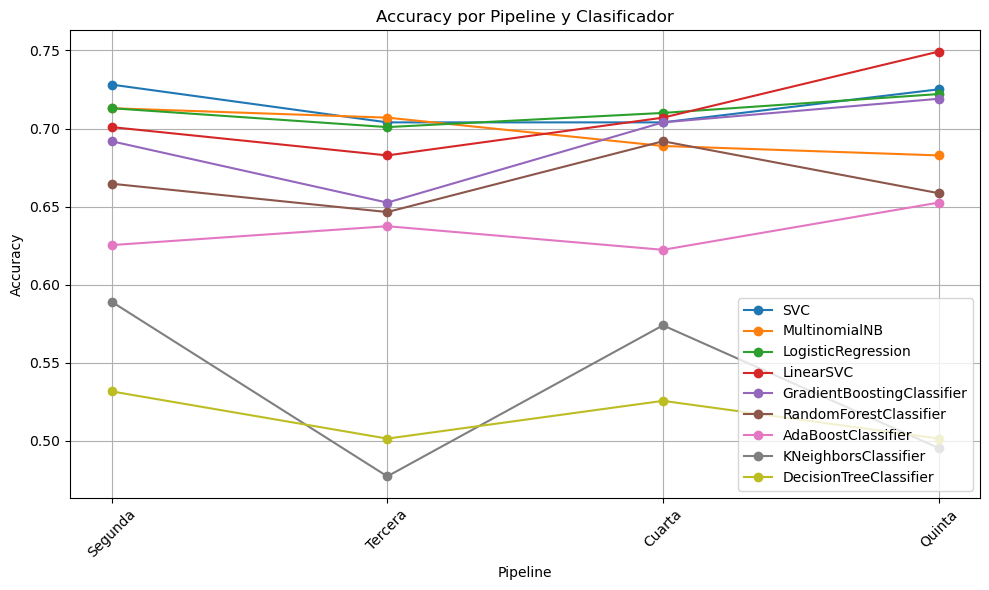

In [35]:


dataos_Resultados = {
    'Pipeline': ['Segunda', 'Tercera', 'Cuarta', 'Quinta'],
    'SVC': [0.728097, 0.703927, 0.703927, 0.725076],
    'MultinomialNB': [0.712991, 0.706949, 0.688822, 0.682779],
    'LogisticRegression': [0.712991, 0.700906, 0.709970, 0.722054],
    'LinearSVC': [0.700906, 0.682779, 0.706949, 0.749245],
    'GradientBoostingClassifier': [0.691843, 0.652568, 0.703927, 0.719033],
    'RandomForestClassifier': [0.664653, 0.646526, 0.691843, 0.658610],
    'AdaBoostClassifier': [0.625378, 0.637462, 0.622356, 0.652568],
    'KNeighborsClassifier': [0.589124, 0.477341, 0.574018, 0.495468],
    'DecisionTreeClassifier': [0.531722, 0.501511, 0.525680, 0.501511]
}

df = pd.DataFrame(dataos_Resultados)

plt.figure(figsize=(10, 6))

for classifier in df.columns[1:]:
    plt.plot(df['Pipeline'], df[classifier], marker='o', label=classifier)

plt.title('Accuracy por Pipeline y Clasificador')
plt.xlabel('Pipeline')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


A lo largo de la resolución del ejercicio he creado y seguido diferentes estrategias encapsuladas en 5 pipelines para la clasificación de opiniones de la plataforma TripAdvisor.

Los resultados de las diferentes pipelines y los diferentes clasificadores para cada una se muestran en el gráfico anterior. La mejora de las diferentes estrategias no es muy notable respecto a los resultados del pipeline básico proporcionado por los profesores. Esto puede ser debido a la división del conjunto de datos o a la naturaleza de estos.

Como conclusiones finales, en este primer ejercicio de la primera práctica del bloque 2 de la asignatura Mineria de Textos, he aprendido a crear pipelines para la clasificación de textos, en este caso opiniones.

La creación de pipelines es de gran utilidad ya que permite almacenar en una función diferentes procesos, para poder ejecutarlos de manera automatizada en diferentes conjuntos de datos.

